In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

mkdir: /Users/jithujoji/.kaggle: File exists


In [3]:
!cp kaggle.json ~/.kaggle

cp: kaggle.json: No such file or directory


In [4]:
!kaggle datasets download -d aymenabb/ddos-evaluation-dataset-cic-ddos2019

ddos-evaluation-dataset-cic-ddos2019.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip ddos-evaluation-dataset-cic-ddos2019

Archive:  ddos-evaluation-dataset-cic-ddos2019.zip
replace Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [36]:
import pandas as pd
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [37]:
data = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
data.head

<bound method NDFrame.head of                                         Flow ID       Source IP   Source Port  \
0       192.168.10.5-104.16.207.165-54865-443-6  104.16.207.165           443   
1         192.168.10.5-104.16.28.216-55054-80-6   104.16.28.216            80   
2         192.168.10.5-104.16.28.216-55055-80-6   104.16.28.216            80   
3       192.168.10.16-104.17.241.25-46236-443-6   104.17.241.25           443   
4       192.168.10.5-104.19.196.102-54863-443-6  104.19.196.102           443   
...                                         ...             ...           ...   
225740     192.168.10.15-72.21.91.29-61374-80-6     72.21.91.29            80   
225741     192.168.10.15-72.21.91.29-61378-80-6     72.21.91.29            80   
225742     192.168.10.15-72.21.91.29-61375-80-6     72.21.91.29            80   
225743    192.168.10.15-8.41.222.187-61323-80-6    8.41.222.187            80   
225744      192.168.10.15-8.43.72.21-61326-80-6      8.43.72.21            80  

In [38]:
data.shape

(225745, 85)

In [39]:
# Define a function to hash an IP address
def hash_ip(ip):
    return int(hashlib.sha256(ip.encode()).hexdigest(), 16) % 10**8

In [40]:
# 1 Preprocessing
def preprocess_data(df):
    label_encoder = LabelEncoder()
    df[" Label"] = label_encoder.fit_transform(df[" Label"])
    df = df.drop("Flow ID", axis=1)
    # Apply the hash function to the entire 'IP_Address' column
    df[' Source IP'] = df[' Source IP'].apply(hash_ip)
    df[' Destination IP'] = df[' Destination IP'].apply(hash_ip)
    # Convert the 'Timestamp' column to datetime format
    df[' Timestamp'] = pd.to_datetime(df[' Timestamp'], format='%m/%d/%Y %H:%M')

    # Extract features and create new columns
    df['Year'] = df[' Timestamp'].dt.year
    df['Month'] = df[' Timestamp'].dt.month
    df['Day'] = df[' Timestamp'].dt.day
    df['Hour'] = df[' Timestamp'].dt.hour
    df['Minute'] = df[' Timestamp'].dt.minute

    df = df.drop(" Timestamp", axis=1)

    # Replace infinity with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with missing values
    df.dropna(inplace=True)

    return df

In [41]:
# 2. Feature Selection
def select_features(X_train, y_train):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    feature_selector = SelectFromModel(rf, prefit=True)
    return feature_selector.transform(X_train), feature_selector.transform(X_test)

In [42]:
#3. Model Training
def train_models(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier()
    nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300)
    gb = GradientBoostingClassifier()

    rf.fit(X_train, y_train)
    nn.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    # Evaluate accuracy of each model
    rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
    nn_accuracy = accuracy_score(y_test, nn.predict(X_test))
    gb_accuracy = accuracy_score(y_test, gb.predict(X_test))

    return rf, nn, gb, rf_accuracy, nn_accuracy, gb_accuracy

In [43]:
# 4. Ensemble Prediction
def ensemble_predict(rf, nn, gb, X_train, y_train, X_test):
    rf_pred_train = rf.predict(X_train)
    nn_pred_train = nn.predict(X_train)
    gb_pred_train = gb.predict(X_train)

    meta_input_train = pd.DataFrame({'rf': rf_pred_train, 'nn': nn_pred_train, 'gb': gb_pred_train})
    meta_model = LogisticRegression()
    meta_model.fit(meta_input_train, y_train)

    rf_pred_test = rf.predict(X_test)
    nn_pred_test = nn.predict(X_test)
    gb_pred_test = gb.predict(X_test)

    meta_input_test = pd.DataFrame({'rf': rf_pred_test, 'nn': nn_pred_test, 'gb': gb_pred_test})
    final_pred_test = meta_model.predict(meta_input_test)
    return final_pred_test

In [44]:
# Main Execution

# Print the columns to check if ' Label' has leading/trailing whitespaces
print(data.columns)

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

data = preprocess_data(data)

# Separate features (X) and target labels (y)
X = data.drop(' Label', axis=1)  # Assuming 'Label' is the correct column name without leading/trailing whitespaces
y = data[' Label']

# Handle large values or division by zero using MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on your data
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Clip values to avoid infinity or too large values
X_scaled = X_scaled.clip(lower=0, upper=1)

# Split scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.9, random_state=42)

# Imputation using mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Use the same imputer to transform your test data
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Create a pipeline with feature selection using SelectFromModel and RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('imputer', imputer),
    ('feature_selection', SelectFromModel(estimator=rf)),
])

# Fit and transform the pipeline on your training data
X_train_selected = pipeline.fit_transform(X_train_imputed, y_train)

# Use the same pipeline to transform your test data
X_test_selected = pipeline.transform(X_test_imputed)

# Train base models on training set and evaluate on testing set
rf, nn, gb, rf_accuracy_test, nn_accuracy_test, gb_accuracy_test = train_models(X_train_selected, y_train, X_test_selected, y_test)

print("Random Forest Accuracy on Testing Set:", rf_accuracy_test)
print("Neural Network Accuracy on Testing Set:", nn_accuracy_test)
print("Gradient Boosting Accuracy on Testing Set:", gb_accuracy_test)

# Ensemble Prediction
final_pred_test = ensemble_predict(rf, nn, gb, X_train_selected, y_train, X_test_selected)

# Evaluate ensemble accuracy on testing set
ensemble_accuracy_test = accuracy_score(y_test, final_pred_test)
print("Ensemble Accuracy on Testing Set:", ensemble_accuracy_test)


Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

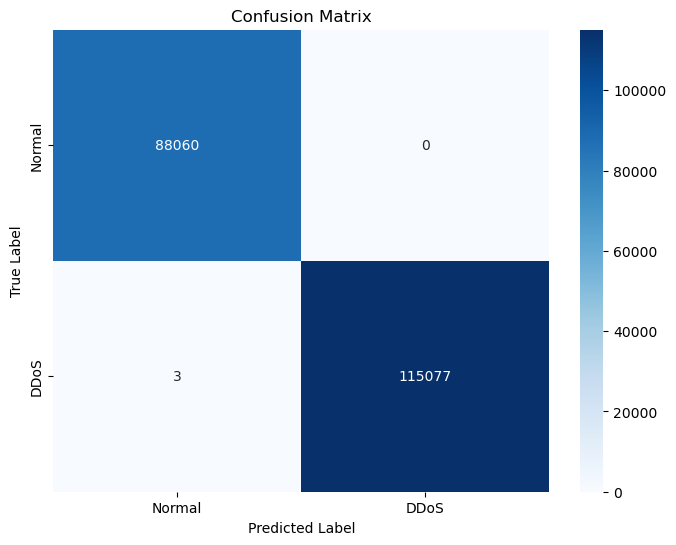

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, final_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [46]:
pd.set_option('display.max_columns', None)
data.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Year,Month,Day,Hour,Minute
0,67598372,31383,17839773,80,6,9392887,4,0,24,0,6,6,6.000000,0.000000,0,0,0.000000,0.000000,2.555125e+00,0.425854,3.130962e+06,5.421269e+06,9390905,975,9392887,3.130962e+06,5.421269e+06,9390905,975,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,80,0,0.425854,0.000000,6,6,6.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,7.500000,6.000000,0.000000,80,0,0,0,0,0,0,4,24,0,0,256,-1,3,20,1.982000e+03,0.0000,1982,1982,9390905.0,0.0000,9390905,9390905,1,2017,7,7,4,8
1,17839773,80,67598372,64007,6,5438011,1,5,6,30,6,6,6.000000,0.000000,6,6,6.000000,0.000000,6.620068e+00,1.103345,1.087602e+06,2.416784e+06,5410860,3,0,0.000000e+00,0.000000e+00,0,0,5422871,1.355718e+06,2.703434e+06,5410860,3,0,0,0,0,20,100,0.183891,0.919454,6,6,6.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,5,7.000000,6.000000,6.000000,20,0,0,0,0,0,0,1,6,5,30,229,0,0,20,2.715100e+04,0.0000,27151,27151,5410860.0,0.0000,5410860,5410860,0,2017,7,7,4,15
2,98096921,51134,52353895,80,6,115615609,20,15,1728,3463,578,0,86.400000,211.017934,1734,0,230.866667,514.538471,4.489878e+01,0.302727,3.400459e+06,4.722346e+06,10100000,17,116000000,6.085032e+06,5.002940e+06,10200000,118,113000000,8.061410e+06,4.296214e+06,10200000,121410,0,0,0,0,648,488,0.172987,0.129740,0,1734,144.194444,368.503446,1.357948e+05,0,0,0,1,0,0,0,0,0,148.314286,86.400000,230.866667,648,0,0,0,0,0,0,20,1728,15,3463,29200,255,3,32,1.609163e+05,134508.6864,566475,120118,10100000.0,46752.4843,10100000,9988018,0,2017,7,7,4,22
3,67598372,14102,17839773,80,6,9827,3,5,26,11601,20,0,8.666667,10.263203,7300,0,2320.200000,3022.508098,1.183169e+06,814.083647,1.403857e+03,2.919354e+03,7954,4,8005,4.002500e+03,5.654733e+03,8001,4,9780,2.445000e+03,3.835651e+03,8150,190,0,0,0,0,72,112,305.281368,508.802279,0,7300,1291.888889,2460.652985,6.054813e+06,0,0,0,1,0,0,0,0,1,1453.375000,8.666667,2320.200000,72,0,0,0,0,0,0,3,26,5,11601,8192,229,2,20,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,1,2017,7,7,3,56
4,17839773,80,67598372,53315,6,87583370,7,9,11607,62,4380,0,1658.142857,1762.272815,20,0,6.888889,5.301991,1.332331e+02,0.182683,5.838891e+06,2.130000e+07,82600000,0,87600000,1.460000e+07,3.540000e+07,86800000,49,86900000,1.090000e+07,2.900000e+07,82600000,0,0,0,0,0,152,192,0.079924,0.102759,0,4380,686.764706,1366.162670,1.866400e+06,0,0,0,0,1,1,0,0,1,729.687500,1658.142857,6.888889,152,0,0,0,0,0,0,7,11607,9,62,229,256,5,20,4.219842e+06,0.0000,4219842,4219842,82600000.0,0.0000,82600000,82600000,0,2017,7,7,4,7


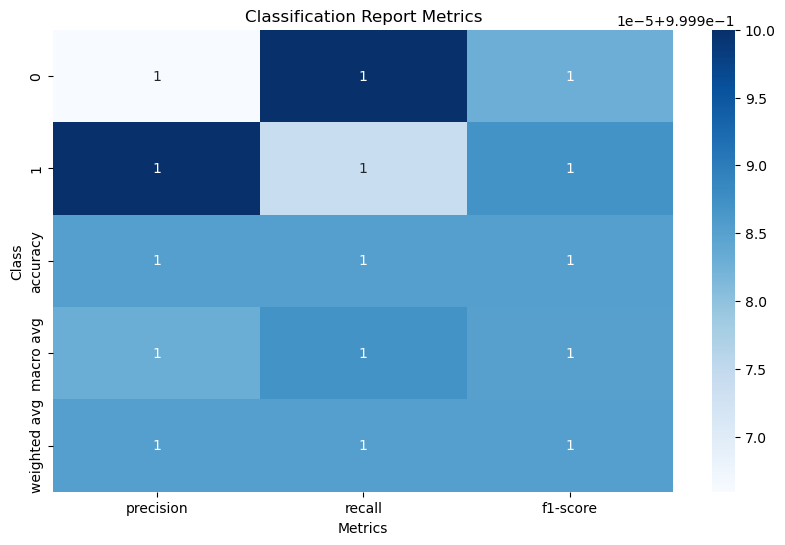

In [47]:
# Parse classification report and convert to dataframe
class_report_df = pd.DataFrame(classification_report(y_test, final_pred_test, output_dict=True)).T

# Plot precision, recall, and f1-score
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='Blues')
plt.title('Classification Report Metrics')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.show()

In [49]:
# Calculate additional metrics
precision = class_report_df.loc['weighted avg', 'precision']
recall = class_report_df.loc['weighted avg', 'recall']
f1_score = class_report_df.loc['weighted avg', 'f1-score']

# Create a summary table
metrics_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [ensemble_accuracy_test, precision, recall, f1_score]
})

print(metrics_summary)


      Metric     Value
0   Accuracy  0.999985
1  Precision  0.999985
2     Recall  0.999985
3   F1-Score  0.999985
